In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime

In [82]:
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if root_path not in sys.path:
    sys.path.append(root_path)
from fileDir import getDataDir, getModelDir, getPredDir

In [83]:
df = pd.read_csv(getDataDir("train", 0))
df.head()

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,r_allloan_amount,r_additional_income,r_spouse_income,r_generalcode1,r_generalcode2,r_generalcode3,r_generalcode4,r_generalcode5,apply,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0,0.0,0.0,NaN,NaN,2.0,4.0,4.0,WI,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,0,5000.0,0.0,NaN,NaN,1.0,4.0,4.0,WI,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,10000,NaN,NaN,NaN,NaN,1.0,2.0,4.0,DS,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,0,0.0,0.0,NaN,NaN,1.0,4.0,4.0,WI,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,0,0.0,0.0,NaN,NaN,1.0,4.0,4.0,DS,1


In [84]:
df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"], errors="coerce")
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce")

In [85]:
df["age"] = (((df["pms_i_ymd"] - df["date_of_birth"]).dt.days / 365).astype(int))
df["months_at_residence"] = df["living_period_year"] * 12 + df["living_period_month"]
df["months_at_job"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
df["total_income"] = df["c_monthly_salary"] + df["r_additional_income"]
#df["debt_to_income_ratio"] = df["r_allloan_amount"] / (df["total_income"] + 1)
#df["loan_burden_per_income"] = df["r_expected_credit_limit"] / (df["total_income"] + 1)

In [86]:
df.head()

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,r_generalcode2,r_generalcode3,r_generalcode4,r_generalcode5,apply,default_12month,age,months_at_residence,months_at_job,total_income
0,202412000001,2018-04-02,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971-05-18,1,2,...,NaN,2.0,4.0,4.0,WI,0,46,60,60,9070.0
1,202412000002,2018-04-02,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983-01-05,1,0,...,NaN,1.0,4.0,4.0,WI,0,35,48,64,16765.0
2,202412000003,2018-04-03,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992-11-19,1,0,...,NaN,1.0,2.0,4.0,DS,0,25,62,3,NaN
3,202412000004,2018-04-04,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990-11-03,1,2,...,NaN,1.0,4.0,4.0,WI,0,27,51,51,13659.0
4,202412000005,2018-04-04,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994-12-16,3,1,...,NaN,1.0,4.0,4.0,DS,1,23,4,2,7440.0


In [87]:
df.shape

(32524, 46)

In [88]:
df.columns

Index(['ID', 'pms_i_ymd', 'Area', 'Province', 'Shop Name', 'gender',
       'date_of_birth_week', 'date_of_birth', 'marital_status',
       'number_of_children', 'postal_code', 'tel_category',
       'number_of_resident', 'living_period_year', 'living_period_month',
       'type_of_residence', 'c_postal_code', 'c_business_type',
       'c_number_of_employee', 'c_position', 'c_occupation',
       'c_employment_status', 'c_monthly_salary', 'c_number_of_working_year',
       'c_number_of_working_month', 'c_salary_payment_methods',
       'c_date_of_salary_payment', 'media', 'place_for_sending_information',
       'r_expected_credit_limit', 'r_propose', 'r_allloan_case',
       'r_allloan_amount', 'r_additional_income', 'r_spouse_income',
       'r_generalcode1', 'r_generalcode2', 'r_generalcode3', 'r_generalcode4',
       'r_generalcode5', 'apply', 'default_12month', 'age',
       'months_at_residence', 'months_at_job', 'total_income'],
      dtype='object')

In [89]:
df = df.drop(columns=["ID", "pms_i_ymd", "Area", "Province", "Shop Name", "date_of_birth_week", "date_of_birth", "marital_status", "number_of_children", "postal_code", "tel_category", "number_of_resident", "living_period_year", "living_period_month", "c_number_of_working_year", "c_postal_code", "c_number_of_working_month", "c_salary_payment_methods", "c_date_of_salary_payment", "media", "place_for_sending_information", "r_propose", "r_allloan_case", "r_allloan_amount", "r_generalcode4", "r_generalcode5"])
df.columns

Index(['gender', 'type_of_residence', 'c_business_type',
       'c_number_of_employee', 'c_position', 'c_occupation',
       'c_employment_status', 'c_monthly_salary', 'r_expected_credit_limit',
       'r_additional_income', 'r_spouse_income', 'r_generalcode1',
       'r_generalcode2', 'r_generalcode3', 'apply', 'default_12month', 'age',
       'months_at_residence', 'months_at_job', 'total_income'],
      dtype='object')

In [90]:
df = df.dropna(axis=1, thresh=len(df)*0.6)

df.columns

Index(['gender', 'type_of_residence', 'c_business_type',
       'c_number_of_employee', 'c_position', 'c_occupation',
       'c_employment_status', 'c_monthly_salary', 'r_expected_credit_limit',
       'r_additional_income', 'r_spouse_income', 'r_generalcode3', 'apply',
       'default_12month', 'age', 'months_at_residence', 'months_at_job',
       'total_income'],
      dtype='object')

In [91]:
df.head()

,gender,type_of_residence,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_monthly_salary,r_expected_credit_limit,r_additional_income,r_spouse_income,r_generalcode3,apply,default_12month,age,months_at_residence,months_at_job,total_income
0,F2,6,7,9999,5,55,5,9070,40000.0,0.0,0.0,2.0,WI,0,46,60,60,9070.0
1,M,6,7,500,5,55,5,11765,20000.0,5000.0,0.0,1.0,WI,0,35,48,64,16765.0
2,F2,3,7,1000,4,53,5,10420,20000.0,NaN,NaN,1.0,DS,0,25,62,3,NaN
3,M,5,3,500,5,55,2,13659,15000.0,0.0,0.0,1.0,WI,0,27,51,51,13659.0
4,F2,4,7,1000,5,55,5,7440,10000.0,0.0,0.0,1.0,DS,1,23,4,2,7440.0


In [92]:
df = df.drop(columns=["r_spouse_income", "c_number_of_employee", "type_of_residence"])
df.columns

Index(['gender', 'c_business_type', 'c_position', 'c_occupation',
       'c_employment_status', 'c_monthly_salary', 'r_expected_credit_limit',
       'r_additional_income', 'r_generalcode3', 'apply', 'default_12month',
       'age', 'months_at_residence', 'months_at_job', 'total_income'],
      dtype='object')

In [93]:
categorical_cols = [
    "gender", "c_business_type", "c_position",
    "c_occupation", "c_employment_status",
    "c_employment_status",
    "r_generalcode3", "apply"
]

for col in categorical_cols:
    df[col] = df[col].astype("category")

In [94]:
from sklearn.impute import SimpleImputer

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Create imputers
num_imputer = SimpleImputer(strategy='median')           # for numeric columns
cat_imputer = SimpleImputer(strategy='most_frequent')    # for categorical columns

# Fit and transform
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [95]:
from sklearn.preprocessing import LabelEncoder
df[["gender", "apply", "r_generalcode3"]] = df[["gender", "apply", "r_generalcode3"]].apply(LabelEncoder().fit_transform)

In [96]:
# Loop through each numeric column and remove outliers
numeric_cols = list(numeric_cols)
numeric_cols.remove("default_12month") 
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)   # 25th percentile
    Q3 = df[col].quantile(0.75)   # 75th percentile
    IQR = Q3 - Q1                 # Interquartile Range
    lower = Q1 - 1.5 * IQR        # Lower bound
    upper = Q3 + 1.5 * IQR        # Upper bound

    # Keep only the rows within the bounds
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [97]:
df = df.drop(columns=["gender", "c_business_type", "c_occupation", "c_employment_status"])
df.head()

,c_position,c_monthly_salary,r_expected_credit_limit,r_additional_income,r_generalcode3,apply,default_12month,age,months_at_residence,months_at_job,total_income
2,4,10420.0,20000.0,0.0,1,0,0.0,25.0,62.0,3.0,12084.0
3,5,13659.0,15000.0,0.0,1,4,0.0,27.0,51.0,51.0,13659.0
4,5,7440.0,10000.0,0.0,1,0,1.0,23.0,4.0,2.0,7440.0
5,4,9360.0,5000.0,0.0,2,4,0.0,24.0,24.0,36.0,9360.0
6,4,9360.0,5000.0,0.0,1,4,0.0,25.0,300.0,36.0,9360.0


[0. 1.] [15992  2606]


<Axes: >

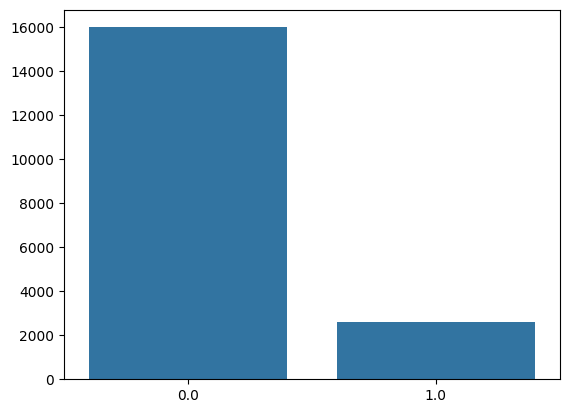

In [98]:
import numpy as np
import seaborn as sns
(unique, counts) = np.unique(df["default_12month"], return_counts=True)
print(unique,counts)
sns.barplot(x=unique, y=counts)

In [99]:
df.to_csv("C:/Users/chins/Desktop/123/Aihack_aikokkak/data/cleaned_data_v2.csv")

12083
[0. 1.] [3909 2606]


<Axes: >

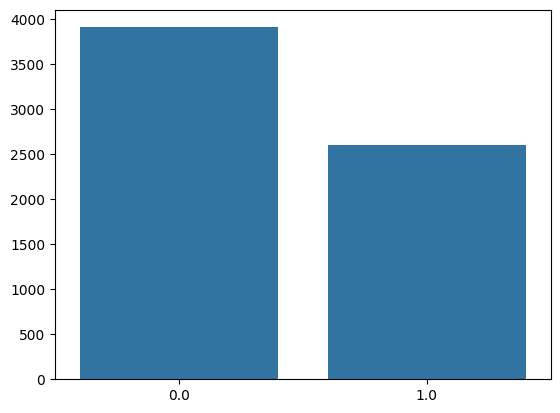

In [100]:
import random
n = (df["default_12month"] == 0).sum() - int(1.5 * (df["default_12month"] == 1).sum())
indexes = df.index[df["default_12month"] == 0].tolist()
index_to_delete = random.sample(indexes, k=min(n, len(indexes)))
df = df.drop(index_to_delete)
print(n)
(unique, counts) = np.unique(df["default_12month"], return_counts=True)
print(unique,counts)
sns.barplot(x=unique, y=counts)